In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb


data_path = "/content/CMAPSSData"

def load_cmapss_dataset(dataset_number):
    """Load all files for a specific CMAPSS dataset (1-4)"""
    base_name = f"FD00{dataset_number}"
    train_file = os.path.join(data_path, f'train_{base_name}.txt')
    test_file = os.path.join(data_path, f'test_{base_name}.txt')
    rul_file = os.path.join(data_path, f'RUL_{base_name}.txt')

    columns = ['unit_number', 'time_cycles'] + \
              [f'operational_setting_{i}' for i in range(1,4)] + \
              [f'sensor_measurement_{i}' for i in range(1,22)]

    train = pd.read_csv(train_file, sep='\s+', header=None, names=columns)
    test = pd.read_csv(test_file, sep='\s+', header=None, names=columns)
    rul = pd.read_csv(rul_file, sep='\s+', header=None, names=['RUL'])

    return train, test, rul

# Load all datasets
datasets = {i: load_cmapss_dataset(i) for i in range(1, 5)}
datasets

# Data Preparation
def add_rul_column(df):
    """Add Remaining Useful Life column with piecewise scaling"""
    max_cycle = df.groupby('unit_number')['time_cycles'].max()
    merged = df.merge(max_cycle.to_frame(name='max_cycle'), on='unit_number')
    merged['RUL'] = merged['max_cycle'] - merged['time_cycles']
    # Piecewise linear scaling
    merged['RUL'] = merged['RUL'].apply(lambda x: x if x <= 125 else 125 + 0.1*(x-125))
    return merged.drop('max_cycle', axis=1)

# XGBoost Model
def build_xgboost_model():
    model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                             max_depth=5, alpha=10, n_estimators=100)
    return model

# Data Preparation Pipeline
def prepare_data(dataset_num, window_size=30, shift=1):
    train, test, rul = datasets[dataset_num]
    train = add_rul_column(train)

    # Select important features (identified from EDA)
    important_sensors = ['sensor_measurement_2', 'sensor_measurement_3',
                        'sensor_measurement_4', 'sensor_measurement_7',
                        'sensor_measurement_8', 'sensor_measurement_11',
                        'sensor_measurement_12', 'sensor_measurement_13',
                        'sensor_measurement_15', 'sensor_measurement_17']
    features = ['operational_setting_1', 'operational_setting_2',
               'operational_setting_3'] + important_sensors

    # Normalize data
    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    # Create sequences for training
    def create_sequences(df, window_size, shift):
        X, y = [], []
        for unit in df['unit_number'].unique():
            unit_data = df[df['unit_number'] == unit]
            for i in range(0, len(unit_data) - window_size, shift):
                X.append(unit_data[features].values[i:i+window_size])
                y.append(unit_data['RUL'].iloc[i+window_size])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train, window_size, shift)

    # Prepare test data
    X_test, y_test = [], []
    for unit in test['unit_number'].unique():
        unit_data = test[test['unit_number'] == unit]
        if len(unit_data) >= window_size:
            X_test.append(unit_data[features].values[-window_size:])
            y_test.append(rul.iloc[unit-1])  # Note: 'rul' is a Series indexed from 0
    return X_train, y_train, np.array(X_test), np.array(y_test), scaler, features

# Evaluation Metrics
def nasa_score(y_true, y_pred):
    diff = y_pred - y_true
    return np.mean(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

def calculate_metrics(y_true, y_pred):
    return {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'nasa_score': nasa_score(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'within_10': np.mean(np.abs(y_pred - y_true) <= 10) * 100,
        'within_20': np.mean(np.abs(y_pred - y_true) <= 20) * 100
    }

# Training and Evaluation
def train_and_evaluate(dataset_num):
    X_train, y_train, X_test, y_test, scaler, features = prepare_data(dataset_num)

    model = build_xgboost_model()

    # Train the model
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

    # Make predictions
    y_pred = model.predict(X_test.reshape(X_test.shape[0], -1))

    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred)

    # Simple Plot: True vs Predicted RUL
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('True RUL')
    plt.ylabel('Predicted RUL')
    plt.title(f'FD00{dataset_num} Predictions (R²: {metrics["r2"]:.2f})')
    plt.grid(True)
    plt.show()

    return model, metrics, scaler, features



Training FD001


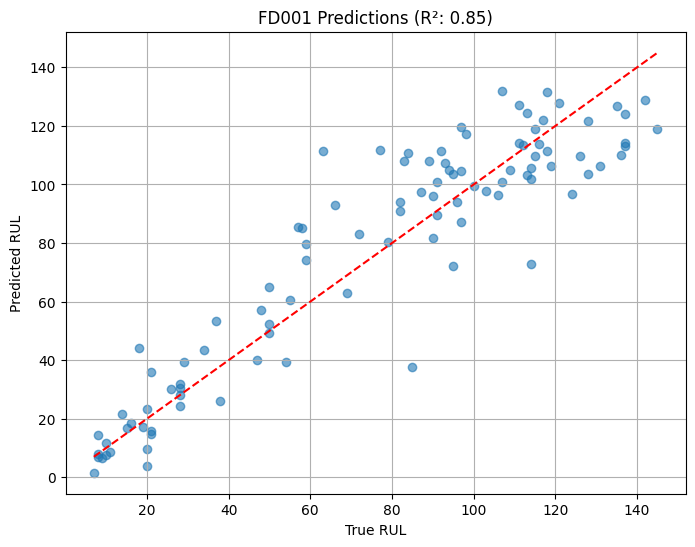


Training FD002


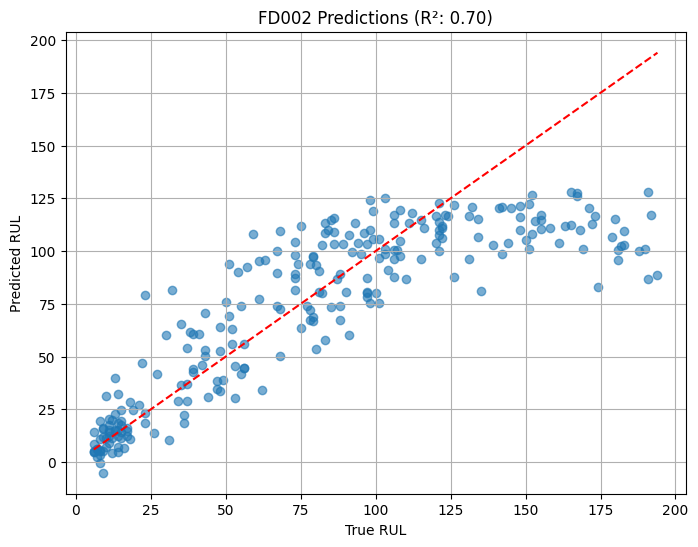


Training FD003


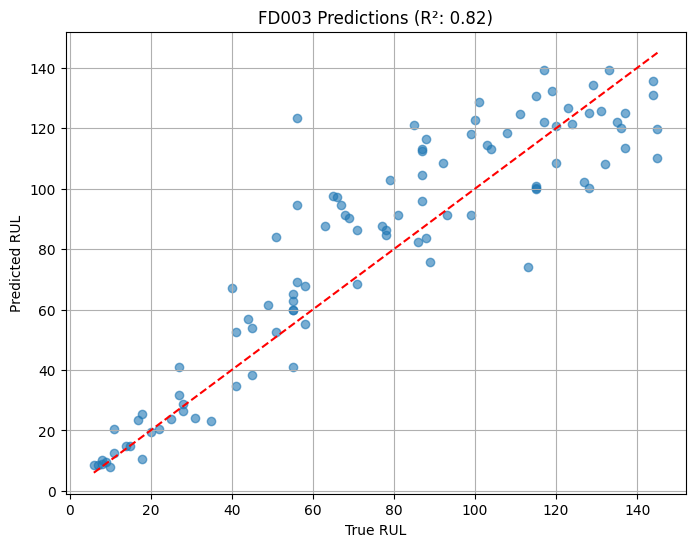


Training FD004


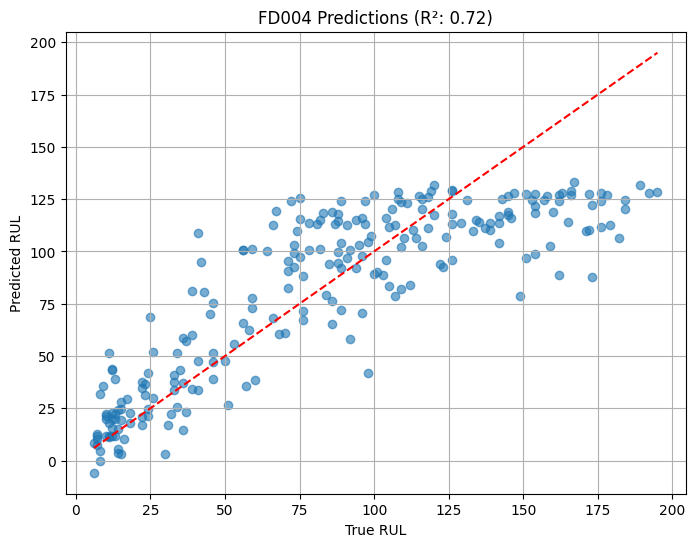


=== Final Results ===

FD001:
Features used: 13 sensors + operational settings
RMSE: 15.83 cycles
MAE: 12.11 cycles
NASA Score: 3618.62
R²: 0.85
Within ±10 cycles: 15.9%
Within ±20 cycles: 30.4%

FD002:
Features used: 13 sensors + operational settings
RMSE: 29.26 cycles
MAE: 20.54 cycles
NASA Score: 15183.53
R²: 0.70
Within ±10 cycles: 12.9%
Within ±20 cycles: 23.5%

FD003:
Features used: 13 sensors + operational settings
RMSE: 17.44 cycles
MAE: 13.21 cycles
NASA Score: 5724.48
R²: 0.82
Within ±10 cycles: 14.0%
Within ±20 cycles: 26.6%

FD004:
Features used: 13 sensors + operational settings
RMSE: 28.36 cycles
MAE: 21.89 cycles
NASA Score: 12935.54
R²: 0.72
Within ±10 cycles: 11.7%
Within ±20 cycles: 22.6%


In [3]:
# Create a directory to store saved models
os.makedirs("saved_models", exist_ok=True)

# Load all datasets
datasets = {i: load_cmapss_dataset(i) for i in range(1, 5)}

# Train and evaluate models
results = {}
for i in range(1, 5):
    print(f"\n{'='*50}")
    print(f"Training FD00{i}")
    print(f"{'='*50}")
    model, metrics, scaler, features = train_and_evaluate(i)

    # Save model to disk
    model_path = f"saved_models/FD00{i}_xgb_model.json"
    model.save_model(model_path)

    results[f'FD00{i}'] = {
        'model': model,
        'metrics': metrics,
        'scaler': scaler,
        'features': features
    }

# Print summary
print("\n=== Final Results ===")
for ds, res in results.items():
    print(f"\n{ds}:")
    print(f"Features used: {len(res['features'])} sensors + operational settings")
    print(f"RMSE: {res['metrics']['rmse']:.2f} cycles")
    print(f"MAE: {res['metrics']['mae']:.2f} cycles")
    print(f"NASA Score: {res['metrics']['nasa_score']:.2f}")
    print(f"R²: {res['metrics']['r2']:.2f}")
    print(f"Within ±10 cycles: {res['metrics']['within_10']:.1f}%")
    print(f"Within ±20 cycles: {res['metrics']['within_20']:.1f}%")
